### 模型说明

该模型最多有3个输入，分别是影响因子，文本数据和图片数据；1个输出，即有用性预测。模型内部可分为3个模块和1个分类器，3个模块分别为影响因子模块`FACTORS_MODULE`，文本数据模块`TEXT_MODULE`和图片数据模块`IMAGE_MODULE`。模型**最少包含**1个模块。

>    影响因子模块用全连接层建立，
>
>    文本数据模块用 LSTM / BERT 建立，
>
>    图片数据模块用 CNN / Xception 建立。

共计需要构建 7 个模型。分类器使用全连接层建立。

In [1]:
%pip install -q tensorflow-text==2.6

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tens

### 配置

In [2]:
### 全局配置 ###
SEED = 3 # 随机数种子
# GRAPHVIZ = "Graphviz/bin"  # no need on kaggle

In [ ]:
# setting
# 影响因子模块设置，("Dense", None), None 为不设置该模块
FACTOR_MODULE: str | None = "Dense" 

# 文本模块设置  "LSTM", "BERT", None
TEXT_MODULE: str | None = "BERT"  

# 图片模块设置  "CNN", "MobileNetV2", None
IMAGE_MODULE: str | None = None  

# 在该模型基础上继续训练，None 为不设置 
LOAD_MODEL: str|None = "../input/modelmoneymouse/DB_model_1.tf"

# 存储模型，前缀DB（Dense与BERT的首字母）表示该模型的结构，若使用了其他模型，请修改前缀。后缀为次数标识，新做一个版本，请修改后缀。
SAVE_MODEL = "DB_model_3.tf"

# 数据集
DATASET = "../input/data-csv-moneymouse/dataset_with_img.csv"

In [3]:
from __future__ import annotations

import os
import random
from pathlib import Path  # 面向对象的路径操作
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub  # 下载预处理模型
import tensorflow_addons as tfa  # tensorflow 扩展
import tensorflow_text as tft  # Jiuh: 使用 BERT Preprocessor 必须先导入 tensorflow-text

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, load_img, img_to_array, array_to_img
from keras.layers import Layer
from keras import backend as K

from PIL import Image  # 图片处理
from IPython.display import display  # 显示表格和图片
import xgboost

# 加入 Graphviz 可执行文件路径。用于显示模型结构
# os.environ["PATH"] += os.pathsep + os.path.abspath(GRAPHVIZ)

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

gpus = tf.config.experimental.list_physical_devices('GPU')
# 设置按需申请
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

### Utils

In [4]:
# 修改 keras.application 模型名
def add_prefix(model, prefix: str, custom_objects=None):
    '''Adds a prefix to layers and model name while keeping the pre-trained weights
    Arguments:
        model: a tf.keras model
        prefix: a string that would be added to after each layer name
        custom_objects: if your model consists of custom layers you shoud add them pass them as a dictionary. 
            For more information read the following:
            https://keras.io/guides/serialization_and_saving/#custom-objects
    Returns:
        new_model: a tf.keras model having same weights as the input model.
    '''
    
    config = model.get_config()
    old_to_new = {}
    new_to_old = {}
    
    for layer in config['layers']:
        new_name = prefix + layer['name']
        old_to_new[layer['name']], new_to_old[new_name] = new_name, layer['name']
        layer['name'] = new_name
        layer['config']['name'] = new_name

        if len(layer['inbound_nodes']) > 0:
            for in_node in layer['inbound_nodes'][0]:
                in_node[0] = old_to_new[in_node[0]]
    
    for input_layer in config['input_layers']:
        input_layer[0] = old_to_new[input_layer[0]]
    
    for output_layer in config['output_layers']:
        output_layer[0] = old_to_new[output_layer[0]]
    
    config['name'] = prefix + config['name']
    new_model = tf.keras.Model().from_config(config, custom_objects)
    
    for layer in new_model.layers:
        layer.set_weights(model.get_layer(new_to_old[layer.name]).get_weights())
    
    return new_model

### 加载数据

In [5]:
data = pd.read_csv(DATASET, low_memory=False, index_col=0)


#data["review is updated 0"] = data["review is updated"].apply(lambda x: int(not x))
#data["review is updated 1"] = data["review is updated"].apply(int)
#data.drop(columns="review funny", inplace=True)  
#data.drop(columns="review is updated", inplace=True)
#data.drop(columns="review cool", inplace=True)

X = data.drop(columns="review useful")

Y = data["review useful"]

In [6]:
X.dtypes

star                            float64
price                             int64
reviews count                     int64
elite                             int64
author friends                    int64
author reviews                    int64
author photos                     int64
author join date(day delta)       int64
author funny votes                int64
author cool votes                 int64
author 5 rating distribution      int64
author 4 rating distribution      int64
author 3 rating distribution      int64
author 2 rating distribution      int64
author 1 rating distribution      int64
review date(day delta)            int64
review rating                     int64
review photos                     int64
review useful original            int64
review text                      object
review reply date(day delta)      int64
img_id                            int64
dtype: object

In [7]:
Y.describe()

count    63384.000000
mean         1.180520
std          0.630369
min          0.693147
25%          0.693147
50%          1.098612
75%          1.386294
max          5.793014
Name: review useful, dtype: float64

### 模块构建

---

##### 影响因子模块

In [8]:
FACTOR_MODULE_OUTPUT_SIZE = 16  # 影响因子模块输出形状 (Batch, OUTPUT_SIZE)

In [9]:
def build_dense_factor_module(data: pd.DataFrame, num_classes):
    # 找到适当的 2^n 来构建模型
    for base in (2**i for i in range(1, 100)):
        if base > FACTOR_MODULE_OUTPUT_SIZE:
            break
    
    # 预处理层
    preprocess = layers.Normalization(name="factor_preprocess")
    preprocess.adapt(data)

    # 模型主体
    i = layers.Input(shape=(data.shape[1],), name="factor_input", dtype=tf.float64)  # 影响因子输入层
    o = preprocess(i)
    o = layers.Dense(base, activation="relu")(o)
    o = layers.Dense(num_classes, name="factor_output")(o)
    
    model = keras.Model(inputs=i, outputs=o)
    
    return model

In [10]:
if FACTOR_MODULE == "Dense":
    factor_batch_x = X.drop(columns=["review text"]) if "img_id" not in X else X.drop(columns=["review text","img_id"])
    factor_module = build_dense_factor_module(
        factor_batch_x,
#         FACTOR_MODULE_OUTPUT_SIZE，
        num_classes=32,
    )

    factor_module.summary()

2022-10-17 16:18:10.011356: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-17 16:18:10.157254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
factor_input (InputLayer)    [(None, 20)]              0         
_________________________________________________________________
factor_preprocess (Normaliza (None, 20)                41        
_________________________________________________________________
dense (Dense)                (None, 32)                672       
_________________________________________________________________
factor_output (Dense)        (None, 32)                1056      
Total params: 1,769
Trainable params: 1,728
Non-trainable params: 41
_________________________________________________________________


---

##### 文本数据模块

In [11]:
TEXT_MODULE_OUTPUT_SIZE = 128  # 文本模块输出形状 (Batch, OUTPUT_SIZE)

MAX_TEXT_LENGTH = 512
MAX_TOKENS = 30_000  # LSTM only

In [12]:
def build_lstm_text_module(text_list: list[str], num_classes, max_tokens, max_text_length):
    # 预处理层
    preprocess = layers.TextVectorization(name="text_preprocess", max_tokens=max_tokens, output_sequence_length=max_text_length)
    preprocess.adapt(text_list)
    
    # 模型主体
    i = layers.Input(shape=(), name="text_input", dtype=tf.string)
    o = preprocess(i)
    o = layers.Embedding(preprocess.vocabulary_size(), 64)(o)
    o = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(o)
    o = layers.Bidirectional(layers.LSTM(128))(o)
    o = layers.Dense(256, activation="relu")(o)
    o = layers.BatchNormalization()(o)
#     o = layers.Dense(128, activation="relu")(o)
#     o = layers.BatchNormalization()(o)

    o = layers.Dense(num_classes, name="text_output")(o)

    model = keras.Model(inputs=i, outputs=o)

    return model


def build_bert_text_module(num_classes, max_text_length):
    # 加载预训练模型
    preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    tokenize = hub.KerasLayer(preprocessor.tokenize, name="tokenize")  # 定制 Tokenizr
    bert_pack_inputs = hub.KerasLayer(  # 调整文本长度
        preprocessor.bert_pack_inputs,
        arguments={"seq_length": max_text_length},
        name="pack_inputs",
    )
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
        trainable=True,
        name="bert",
    )
    
    # 模型主体
    i = tf.keras.layers.Input(shape=(), name="text_input", dtype=tf.string)
    o = tokenize(i)
    o = bert_pack_inputs([o])  # 将令牌化的文本填充/裁剪至指定长度
    o = bert(o)
    # Jiuh: 为什么只需要部分输出可以参见：https://www.cnblogs.com/zackstang/p/15387549.html，
    # https://www.cnblogs.com/zackstang/p/15387549.html
    # Jiuh: pooled_output 代表整个句子的向量表示，实际是 sequence_output 的第一个向量（[CLS] 所代表的向量）
    o = o["pooled_output"]  # [batch_size, 768].
    o = layers.Dense(num_classes, name="text_output")(o)

    model = keras.Model(inputs=i, outputs=o)
    
    return model

In [13]:
if TEXT_MODULE == "BERT":
    text_module = build_bert_text_module(TEXT_MODULE_OUTPUT_SIZE, MAX_TEXT_LENGTH)

    text_module.summary()

elif TEXT_MODULE == "LSTM":
    text_module = build_lstm_text_module(
        X["review text"].tolist(),
        num_classes=TEXT_MODULE_OUTPUT_SIZE,
        max_tokens=MAX_TOKENS,
        max_text_length=MAX_TEXT_LENGTH,
    )
    
    text_module.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
tokenize (KerasLayer)           (None, None, None)   0           text_input[0][0]                 
__________________________________________________________________________________________________
pack_inputs (KerasLayer)        {'input_mask': (None 0           tokenize[0][0]                   
__________________________________________________________________________________________________
bert (KerasLayer)               {'sequence_output':  4385921     pack_inputs[0][0]                
                                                                 pack_inputs[0][1]          

---

##### 图片数据模块

In [14]:
IMAGE_MODULE_OUTPUT_SIZE = 32  # 图片模块输出形状 (Batch, OUTPUT_SIZE)

IMAGE_SHAPE = (224, 224, 3)  # 在模型中的图片形状
NUM_IMAGES = 4

In [15]:
def image_preprocess_layer(input_shape):
    return keras.Sequential(
        [
            # Do nothing at inference time
            #layers.RandomRotation(0.1, name="image_rotate"),  # 随机旋转
            #layers.RandomZoom(0.3, name="image_zoom", fill_mode="constant"),  # 随机缩放
#             layers.RandomFlip(name="image_flip"),  # 随机翻转
            # Allways do
            layers.Resizing(input_shape[0], input_shape[1], name="image_center_crop"),
            layers.Rescaling(1.0 / 127.5, offset=-1, name="image_rescale"),
        ],
        name="image_preprocess",
    )


def build_cnn_image_module(num_images, num_classes, image_shape: tuple[int, int, int]):
    # 预处理层
    preprocess = image_preprocess_layer(image_shape)

    # 模型主体
    i = layers.Input(shape=(num_images, None, None, image_shape[-1]), name="image_input")
    branchs = []
    for image_idx in range(num_images):
        o = layers.Lambda(lambda x: x[:, image_idx])(i)
        o = preprocess(o)
        
        o = layers.Conv2D(16, 3, padding='same', activation='selu')(o)
        o = layers.MaxPooling2D()(o)
        o = layers.Conv2D(32, 3, padding='same', activation='selu')(o)
        o = layers.MaxPooling2D()(o)
        o = layers.Conv2D(64, 3, padding='same')(o)
        o = layers.MaxPooling2D()(o)
        o = layers.GlobalAveragePooling2D()(o)
            
        branchs.append(o)
    
        
#     o = layers.Add(name="image_output")(branchs)  # 合并所有分支
    o = layers.Concatenate()(branchs)
    #o = layers.Dense(64)(o)
    o = layers.Flatten(name="image_output")(o) 

    model = keras.Model(inputs=i, outputs=o)

    return model


def build_mobile_net_v2_image_module(num_images, num_classes, image_shape):
    # 预处理层
    preprocess = image_preprocess_layer(image_shape)
    
    # 模型主体
    i = layers.Input(shape=(num_images, None, None, image_shape[-1]), name="image_input")
    branchs = []
    for image_idx in range(num_images):
        # 加载模型
        app = keras.applications.MobileNetV2(
            pooling="avg", input_shape=image_shape
        )
        app = add_prefix(app, f"{image_idx}_")  # Fix multi app same name error
        
        o = layers.Lambda(lambda x: x[:, image_idx])(i)
        o = preprocess(o)
        o = app(o)
#         output = layers.Dropout(0.5)(output)
        branchs.append(o)
    

#     o = layers.Add()(branchs)  # 合并所有分支
#     o = layers.Dense(num_classes)(o)
    o = layers.Concatenate()(branchs)
    #o = layers.Dense(256)(o)
    o = layers.Flatten(name="image_output")(o) 
    
    model = keras.Model(inputs=i, outputs=o)
    
    return model


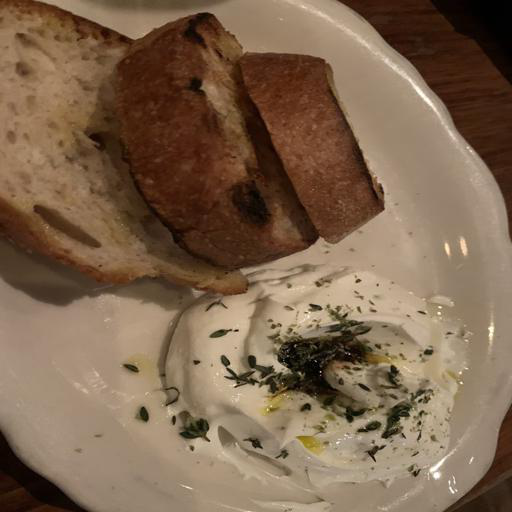

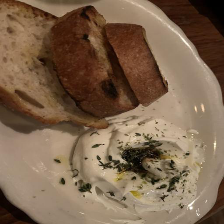

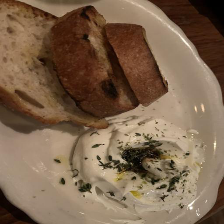

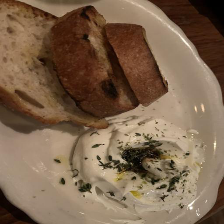

In [16]:
# 图片预处理效果验证
image_preprocess = image_preprocess_layer(IMAGE_SHAPE)

before = load_img("../input/raw-image/raw_images/images/0/1.jpg")
display(before)

for i in range(3):
    after = img_to_array(before)
    after = image_preprocess(after)
    after = array_to_img(after)
    display(after)

In [17]:
if IMAGE_MODULE == "MobileNetV2":
    image_module = build_mobile_net_v2_image_module(NUM_IMAGES, IMAGE_MODULE_OUTPUT_SIZE, IMAGE_SHAPE)
    image_module.summary()

elif IMAGE_MODULE == "CNN":
    image_module = build_cnn_image_module(NUM_IMAGES, IMAGE_MODULE_OUTPUT_SIZE, IMAGE_SHAPE)
    image_module.summary()

### 构建模型

In [18]:
#LOAD_MODEL = "../input/modelweights/model.tf"
# LOAD_MODEL = None

In [19]:
class WeightedSum(Layer):
    def __init__(self, a, **kwargs):
        self.a = a
        #self.b = b
        super(WeightedSum, self).__init__(**kwargs)
    def call(self, model_outputs):
        return (1 - 2*self.a) * model_outputs[0] + self.a * model_outputs[1] + self.a * model_outputs[2]
    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [20]:
class Wt_Add(keras.layers.Layer):
    def __init__(self, units=1, input_dim=1):
        super(Wt_Add, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w1 = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        self.w2 = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )  
        self.w3 = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )       

    def call(self, input1, input2, input3):
        return tf.multiply(input1,self.w1) + tf.multiply(input2, self.w2) + tf.multiply(input3, self.w3)

In [21]:
w_vec = K.constant(np.array([range(3)]*64).reshape(3, 64))

In [22]:
def calcWSumF(x):
    w_vec = K.constant(np.arange(np.shape(x,2)))
    y = K.sum(x * w_vec, axis=-1, keepdims=True)
    return y

In [23]:
def build_model():
    modules = list(filter(bool, [
        factor_module if FACTOR_MODULE else None,
        text_module if TEXT_MODULE else None,
        image_module if IMAGE_MODULE else None,
    ]))
    
    o = layers.Concatenate()([module.output for module in modules])
#    o = tf.keras.layers.Lambda(calcWSumF)([module.output for module in modules])
#    o = layers.Concatenate()(o)
#     o = layers.Dense(512, activation="selu")(o)
#     o = layers.Dense(128, activation="selu")(o)
    o = layers.Dense(1, name="useful", activation='relu')(o)

    model = keras.Model(inputs=[module.input for module in modules], outputs=o)

    return model

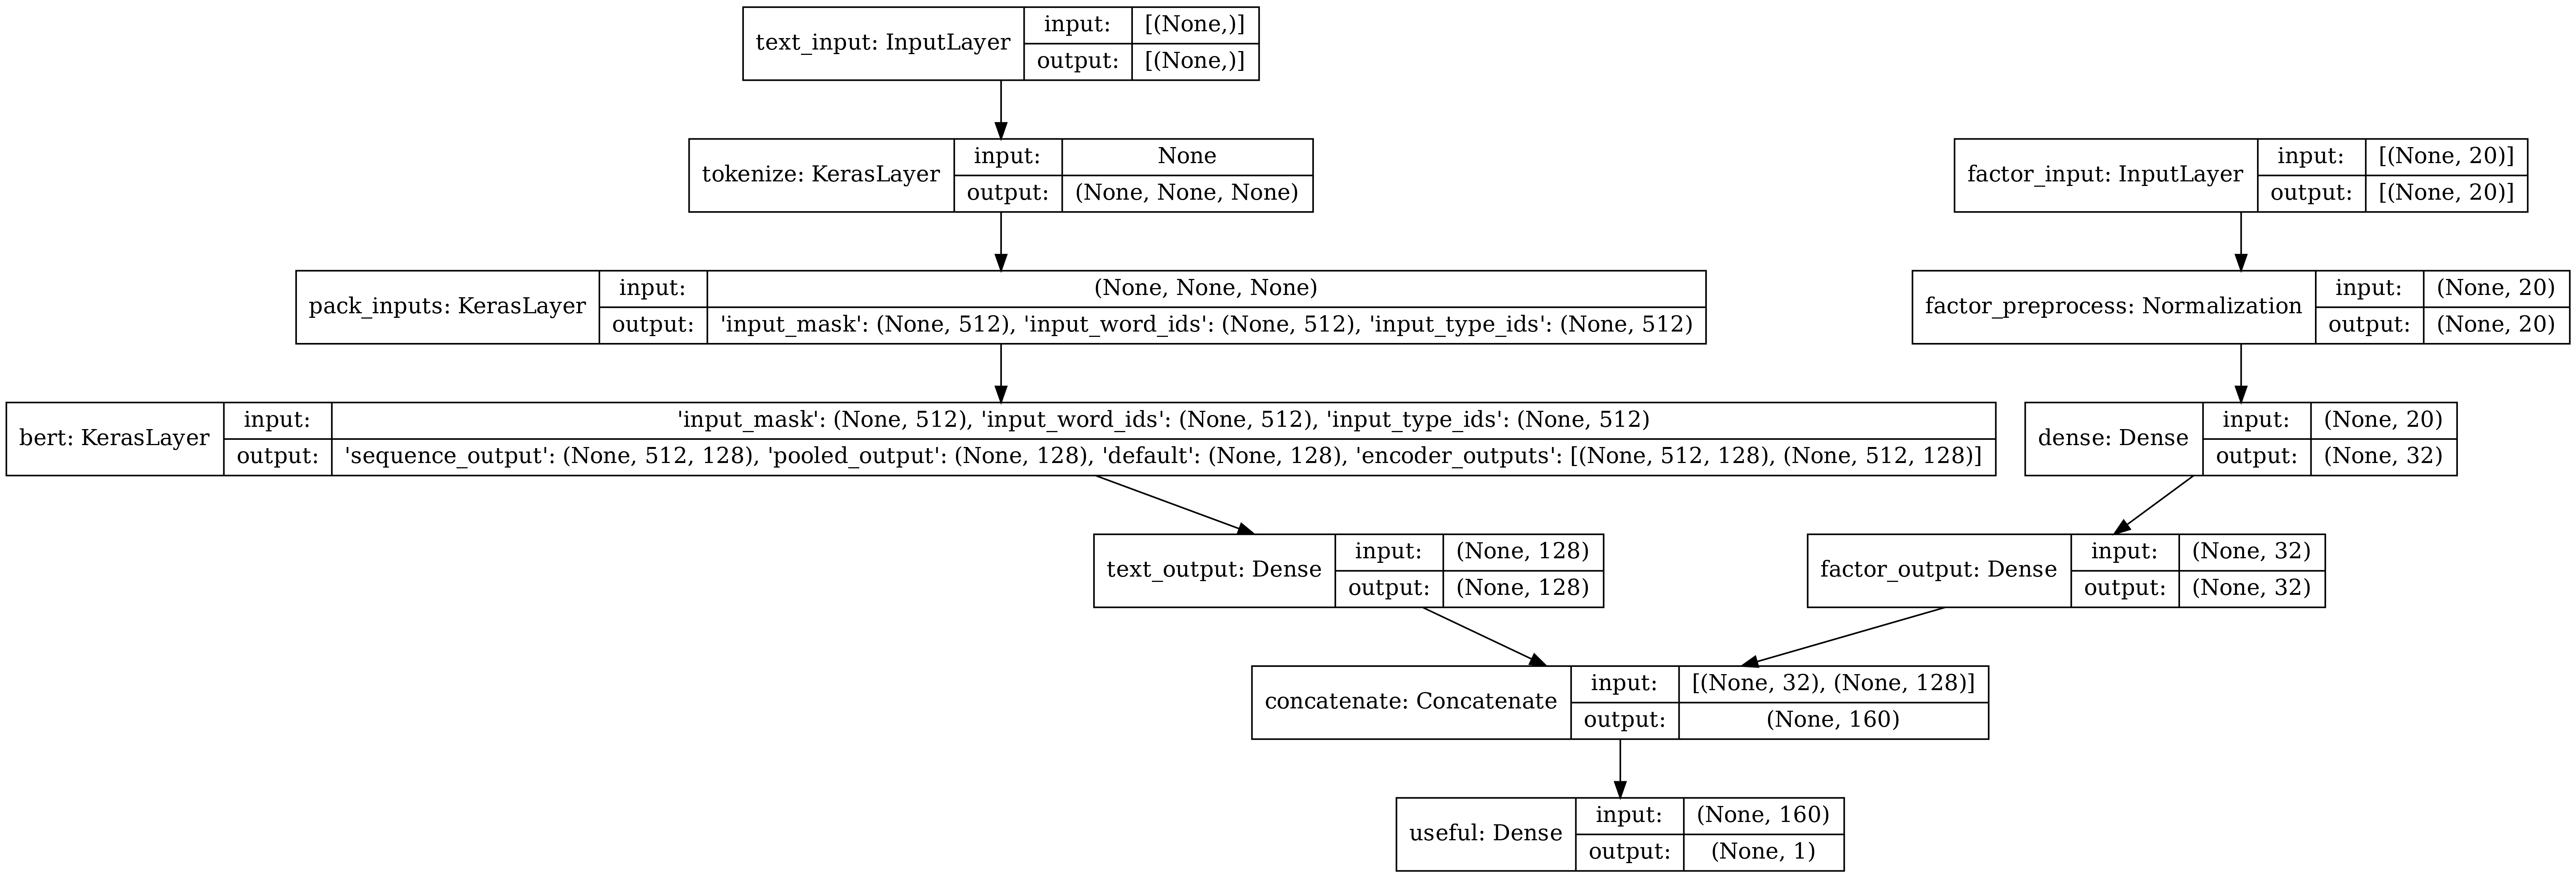

In [24]:
model = build_model()

plot_model(model, dpi=300, show_shapes=True)

### 训练模型

In [25]:
BATCH_SIZE = 32
EPOCHS = 6

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.05  # 过拟合惩罚

IMAGE_DIR = "../input/input/images/images"

构建懒加载数据集

In [26]:
class YelpDataset(keras.utils.Sequence):
    def __init__(self, x, y, batch_size,
                has_factor=True, has_text=True, has_image=True, image_dir=None,
                num_images=None,
        ):
        assert len(x) == len(y)
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.has_factor = has_factor
        self.has_text = has_text
        self.has_image = has_image
        if has_image:
            assert image_dir is not None
            assert num_images is not None
            self.image_dir = Path(image_dir)
            self.num_images = num_images
    
    def __len__(self):
        return len(self.x) // self.batch_size
    
    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size: (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size: (idx + 1) * self.batch_size]
        
        x = {}
        if self.has_factor:
            factor_batch_x = batch_x.drop(columns=["review text"]) if "img_id" not in batch_x else batch_x.drop(columns=["review text","img_id"])
            factor_batch_x = factor_batch_x.values
            x["factor_input"] = factor_batch_x
        if self.has_text:
            text_batch_x = batch_x["review text"]
            text_batch_x = text_batch_x.values
            x["text_input"] = text_batch_x
        if self.has_image:
            image_batch_x = []
            for batch_idx in range(self.batch_size):
                # img_id is the name of the img dir
#                 image_dir =  [self.image_dir / str(img_id) for img_id in batch_x["img_id"].values if img_id!=-1]
#                 images = [load_img(file) for i_dir in image_dir for file in i_dir.iterdir()]  # 加载图片
                image_dir = self.image_dir / str(batch_x.index[batch_idx])
                images = [load_img(file) for file in image_dir.iterdir()]
                random.shuffle(images)  # 确保每个图像模型能充分得到训练
                image_batch_x.append([
                    img_to_array(images[i % len(images)])
                    for i in range(self.num_images)
                ])  # 填充图片
            image_batch_x = np.array(image_batch_x)
            x["image_input"] = image_batch_x
        
        y = batch_y.values
        
        return x, y

In [27]:
TRAIN_VAL_TEST_SPLIT = (6, 2, 2)

indices = np.arange(len(data))
np.random.shuffle(indices)
base = len(data) // sum(TRAIN_VAL_TEST_SPLIT)

train_indices = indices[: base * TRAIN_VAL_TEST_SPLIT[0]]
val_indices = indices[base * TRAIN_VAL_TEST_SPLIT[0] : base * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1])]
test_indices = indices[base * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1]): ]

train_x = X.iloc[: base * TRAIN_VAL_TEST_SPLIT[0]]
train_y = Y.iloc[: base * TRAIN_VAL_TEST_SPLIT[0]]
val_x = X.iloc[base * TRAIN_VAL_TEST_SPLIT[0] : base * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1])]
val_y = Y.iloc[base * TRAIN_VAL_TEST_SPLIT[0] : base * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1])]
test_x = X.iloc[base * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1]): ]
test_y = Y.iloc[base * (TRAIN_VAL_TEST_SPLIT[0] + TRAIN_VAL_TEST_SPLIT[1]): ]

kwargs = {
    "batch_size": BATCH_SIZE,
    "has_factor": bool(FACTOR_MODULE),
    "has_text": bool(TEXT_MODULE),
    "has_image": bool(IMAGE_MODULE),  
    "image_dir": IMAGE_DIR,
    "num_images": NUM_IMAGES,
}

# train_x = train_x.iloc[:1000]
# train_y = train_y.iloc[:1000]
# val_x = val_x.iloc[:100]
# val_y = val_y.iloc[:100]
# test_x = test_x.iloc[:100]
# test_y = test_y.iloc[:100]

#test_x.to_csv("test.csv")

test_x['review date(day delta)'].iloc[20] = 383
test_x['review reply date(day delta)'].iloc[20] = 0
test_x['author join date(day delta)'].iloc[20] = 3096

train_dataset = YelpDataset(train_x, train_y, **kwargs)
val_dataset = YelpDataset(val_x, val_y, **kwargs)
test_dataset = YelpDataset(test_x, test_y, **kwargs)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [28]:
str(train_dataset[0])[:300]

"({'factor_input': array([[4.000e+00, 3.000e+00, 8.540e+02, 0.000e+00, 6.000e+00, 1.890e+02,\n        2.390e+02, 2.658e+03, 2.500e+01, 3.500e+01, 4.700e+01, 6.700e+01,\n        3.600e+01, 2.300e+01, 1.600e+01, 1.100e+03, 2.000e+00, 5.000e+00,\n        1.000e+00, 0.000e+00],\n       [4.000e+00, 2.000e+00,"

开始训练

In [29]:
def mape(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.abs((y_pred - y_true) / y_true)) * 100

def smape(y_true, y_pred):
    return (2.0 * tf.math.reduce_mean(tf.math.abs(y_pred - y_true) / (tf.math.abs(y_pred) + tf.math.abs(y_true))) * 100)

def maape(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.atan(tf.math.abs((y_pred - y_true) / y_true)))

def rmspe(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square((y_pred - y_true) / y_true))) * 100


In [30]:
model.compile(
#     optimizer=tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    optimizer=tfa.optimizers.LAMB(learning_rate=LEARNING_RATE),
#     loss=keras.losses.LogCosh(),
    loss="mse",
    metrics=[
        "mse",
        mape,
        smape,
        maape,
        rmspe,
#         keras.metrics.MeanAbsolutePercentageError("mape_"),  # mape
        keras.metrics.MeanAbsoluteError("mae"),
        keras.metrics.RootMeanSquaredError("rmse"),
        keras.metrics.MeanSquaredLogarithmicError("msle"),
    ],
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
factor_input (InputLayer)       [(None, 20)]         0                                            
__________________________________________________________________________________________________
tokenize (KerasLayer)           (None, None, None)   0           text_input[0][0]                 
__________________________________________________________________________________________________
factor_preprocess (Normalizatio (None, 20)           41          factor_input[0][0]               
____________________________________________________________________________________________

In [31]:
if LOAD_MODEL is not None:    
    model.load_weights(LOAD_MODEL)
    model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
factor_input (InputLayer)       [(None, 20)]         0                                            
__________________________________________________________________________________________________
tokenize (KerasLayer)           (None, None, None)   0           text_input[0][0]                 
__________________________________________________________________________________________________
factor_preprocess (Normalizatio (None, 20)           41          factor_input[0][0]               
____________________________________________________________________________________________

In [32]:
# 训练模型
if True:
    history = model.fit(
        x=train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        workers=True,
        use_multiprocessing=True
    )

model.save_weights(SAVE_MODEL)

Epoch 1/6
1188/1188 [==============================] - 1917s 2s/step - loss: 0.0228 - mse: 0.0228 - mape: 9.0573 - smape: 8.9138 - maape: 0.0890 - rmspe: 12.5030 - mae: 0.0975 - rmse: 0.1509 - msle: 0.0037 - val_loss: 0.0209 - val_mse: 0.0209 - val_mape: 8.4411 - val_smape: 8.1863 - val_maape: 0.0831 - val_rmspe: 11.6985 - val_mae: 0.0916 - val_rmse: 0.1446 - val_msle: 0.0031
Epoch 2/6
1188/1188 [==============================] - 1843s 2s/step - loss: 0.0192 - mse: 0.0192 - mape: 8.1154 - smape: 8.0072 - maape: 0.0800 - rmspe: 11.1886 - mae: 0.0880 - rmse: 0.1385 - msle: 0.0030 - val_loss: 0.0188 - val_mse: 0.0188 - val_mape: 7.4816 - val_smape: 7.4743 - val_maape: 0.0740 - val_rmspe: 10.1789 - val_mae: 0.0842 - val_rmse: 0.1372 - val_msle: 0.0026
Epoch 3/6
1188/1188 [==============================] - 1653s 1s/step - loss: 0.0166 - mse: 0.0166 - mape: 7.4215 - smape: 7.3477 - maape: 0.0734 - rmspe: 10.1310 - mae: 0.0811 - rmse: 0.1288 - msle: 0.0025 - val_loss: 0.0172 - val_mse: 0.0172

### 模型评估

In [33]:
pd.DataFrame({"影响因子":X.drop(columns=["review text"]).columns})

,影响因子
0,star
1,price
2,reviews count
3,elite
4,author friends
5,author reviews
6,author photos
7,author join date(day delta)
8,author funny votes
9,author cool votes


训练过程

In [34]:
def format_modules(template):
    modules = "+".join(map(str, [FACTOR_MODULE, TEXT_MODULE, IMAGE_MODULE]))
    rendered = template.format(modules=modules)
    return rendered

In [35]:
TRAINING_METRICS_FILENAME = "train_metrics[{modules}].csv"

result = pd.DataFrame(history.history)
result.to_csv(format_modules(TRAINING_METRICS_FILENAME))
result

,loss,mse,mape,smape,maape,rmspe,mae,rmse,msle,val_loss,val_mse,val_mape,val_smape,val_maape,val_rmspe,val_mae,val_rmse,val_msle
0,0.022766,0.022766,9.057346,8.913814,0.089028,12.503018,0.097511,0.150886,0.003717,0.020905,0.020905,8.441078,8.186310,0.083146,11.698464,0.091607,0.144585,0.003148
1,0.019181,0.019181,8.115448,8.007170,0.080015,11.188604,0.088046,0.138495,0.003019,0.018812,0.018812,7.481563,7.474298,0.073987,10.178860,0.084231,0.137158,0.002639
2,0.016597,0.016597,7.421543,7.347711,0.073378,10.131002,0.081119,0.128828,0.002504,0.017245,0.017245,7.115459,7.081107,0.070459,9.605831,0.080777,0.131321,0.002348
3,0.014627,0.014627,6.928561,6.872738,0.068598,9.413834,0.075847,0.120942,0.002186,0.016122,0.016122,6.804987,6.762187,0.067459,9.175299,0.077299,0.126973,0.002167
4,0.012885,0.012885,6.531277,6.489066,0.064756,8.820740,0.071689,0.113512,0.001929,0.016410,0.016410,6.786425,6.650146,0.067258,9.199908,0.077333,0.128101,0.002138
5,0.011728,0.011728,6.164150,6.126214,0.061172,8.306346,0.067783,0.108295,0.001717,0.015619,0.015619,6.533592,6.361964,0.064799,8.858433,0.073907,0.124978,0.001947


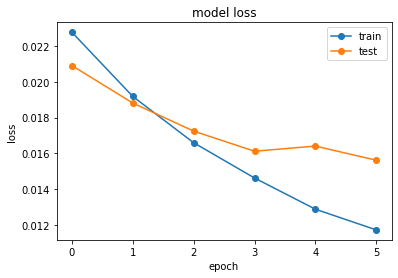

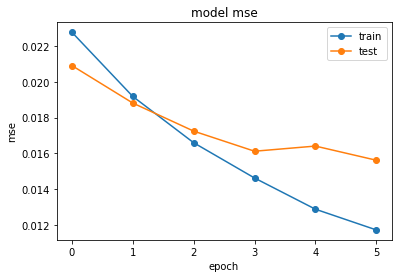

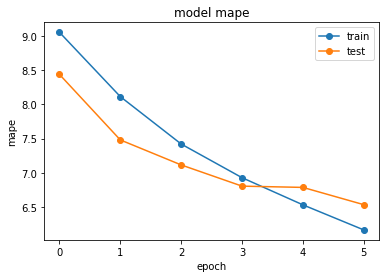

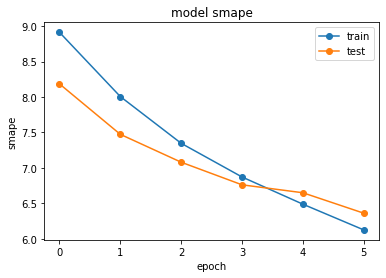

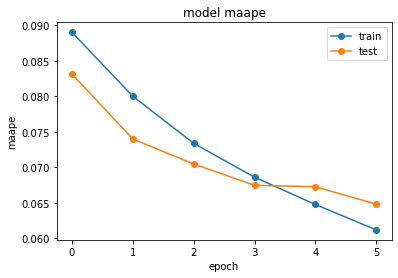

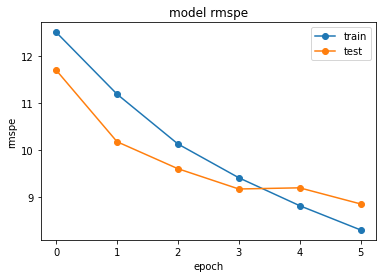

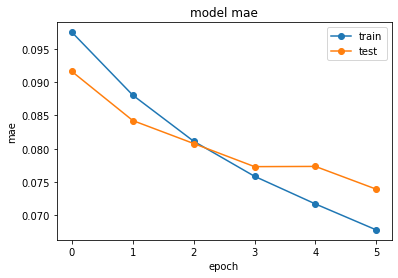

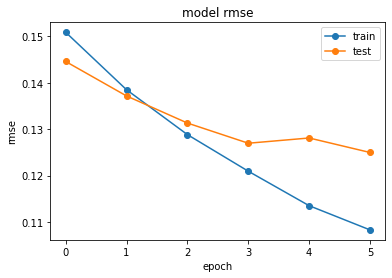

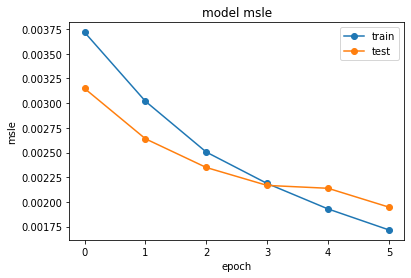

In [36]:
# 显示 history 图像
if True:
    metrics = [name for name in history.history if "val_" not in name]

    for metric in metrics:
        plt.plot(history.history[metric], marker="o")
        plt.plot(history.history[f"val_{metric}"], marker="o")
        plt.title(f"model {metric}")
        plt.ylabel(metric)
        plt.xlabel("epoch")
        plt.legend(["train", "test"], loc="upper right")
        plt.show()

测试集评估

In [37]:
test_y_hat = model.predict(test_dataset, verbose=1)
test_y_hat = test_y_hat.squeeze()

num_test = test_y_hat.shape[0]
test_y_hat = pd.Series(test_y_hat, index=test_y[:num_test].index, name="review useful(predict)")
display(test_y)
display(test_y_hat)

396/396 [==============================] - 157s 394ms/step


7537     0.693147
9171     0.693147
18876    0.693147
44918    1.098612
14981    1.098612
           ...   
48056    0.693147
59011    1.098612
11513    0.693147
1688     0.693147
5994     1.386294
Name: review useful, Length: 12680, dtype: float64

7537     0.702661
9171     0.742940
18876    0.722732
44918    1.052212
14981    1.080333
           ...   
23545    1.466825
43883    1.615909
30410    0.840214
19091    0.770391
11261    0.702569
Name: review useful(predict), Length: 12672, dtype: float32

In [38]:
display(test_y.describe())
display(test_y_hat.describe())

count    12680.000000
mean         1.187370
std          0.632352
min          0.693147
25%          0.693147
50%          1.098612
75%          1.386294
max          5.594711
Name: review useful, dtype: float64

count    12672.000000
mean         1.203488
std          0.627071
min          0.039780
25%          0.734390
50%          1.044636
75%          1.466016
max          8.469482
Name: review useful(predict), dtype: float64

In [39]:
PREDICT_FILENAME = "predict[{modules}].csv"

test_x = test_dataset.x[:num_test]
test_y = test_dataset.y[:num_test]

test_result = test_x.join([test_y, test_y_hat])
test_result.to_csv(format_modules(PREDICT_FILENAME))
test_result

,star,price,reviews count,elite,author friends,author reviews,author photos,author join date(day delta),author funny votes,author cool votes,...,author 1 rating distribution,review date(day delta),review rating,review photos,review useful original,review text,review reply date(day delta),img_id,review useful,review useful(predict)
7537,4.5,2,2519,1,268,98,134,3357,6,50,...,2,442,5,2,1,Was in Az on vacation and based on the great r...,0,58351,0.693147,0.702661
9171,4.5,2,118,1,112,1019,1851,2839,382,668,...,2,2236,4,1,1,I came here with my sister on our first evenin...,0,31507,0.693147,0.742940
18876,4.5,3,9430,1,210,510,1388,3966,168,334,...,2,1860,4,5,1,My sister &amp; I visited Chicago and this pla...,0,75604,0.693147,0.722732
44918,4.5,2,4018,0,89,28,8,3560,7,8,...,4,2990,5,1,2,Absolutely amazing!! Hands down the best bbq ...,0,15130,1.098612,1.052212
14981,4.0,2,515,0,88,174,80,3560,38,25,...,41,2597,2,2,2,Was excited to see what the buzz is all about ...,0,12445,1.098612,1.080333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23545,4.0,2,2804,0,80,67,48,3173,12,18,...,7,1631,5,1,3,Thoroughly satisfied with the taste of the foo...,0,78718,1.386294,1.466825
43883,4.5,2,6202,1,185,127,706,3084,84,260,...,8,690,5,4,4,Welp...<br>I made it home sweet home for the w...,0,24673,1.609438,1.615909
30410,4.5,3,626,1,114,374,1522,2658,346,567,...,17,1093,3,3,1,"Food was good, but it wasn&#39;t extraordinari...",0,48255,0.693147,0.840214
19091,4.5,3,9430,0,13,45,76,1988,14,31,...,1,1924,5,5,1,I may have been somewhat reluctant to try Girl...,0,75763,0.693147,0.770391


In [40]:
PREDICT_METRICS_FILENAME = "predict_metrics[{modules}].csv"

predict_metrics = model.evaluate(test_dataset, return_dict=True)
predict_metrics = pd.DataFrame([predict_metrics])
predict_metrics.to_csv(format_modules(PREDICT_METRICS_FILENAME))
predict_metrics.head()

396/396 [==============================] - 157s 397ms/step - loss: 0.0131 - mse: 0.0131 - mape: 6.5246 - smape: 6.3794 - maape: 0.0647 - rmspe: 8.9184 - mae: 0.0733 - rmse: 0.1146 - msle: 0.0020


,loss,mse,mape,smape,maape,rmspe,mae,rmse,msle
0,0.013128,0.013128,6.524581,6.379418,0.064661,8.918367,0.073267,0.114578,0.001994
